# LAB SINGULARITY - DENGUE

## IMPORTS

In [84]:
import pandas as pd
import numpy as np
import json as js
import datetime
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns

# sklear imports
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

## COLUMNAS DE INTERES

In [12]:
cols = ["PAC_HOS", "SEXO", "Municipio_ocurrencia",\
     "CON_FIN", "FEC_NOT", "ANO","EDAD",\
     "Departamento_ocurrencia"] 
datos = pd.read_excel("Dengue_todos.xlsx")

KeyboardInterrupt: 

## CLEAN DATOS

In [8]:
#datos.to_csv("df_clean.csv" , index = False, sep = ",", encoding='utf-8')
df = pd.read_csv("df_clean.csv")
clean_df = df.drop(index = df.index[720714:720747])
#clean_df[clean_df.isnull().any(axis=1)]
##clean_df["Departamento_ocurrencia"].unique()[:-1]
data_1 = datos.fillna(1)
numericos = data_1.select_dtypes(include = np.number).reset_index()

NameError: name 'datos' is not defined

## Correlation Matrix

In [24]:
corr = datos.corr()
mapa_temp = corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'}) # Temperature map without correlation
mapa_temp_num = corr.style.background_gradient(cmap='coolwarm').set_precision(2) # Temperature map with correlation

mapa_temp

NameError: name 'datos' is not defined

## CLASE NODO

In [6]:
class Nodo_Dep:
    def __init__(self, dpto_index, dpto_name,\
        next = None,prev = None):  

        self.dpto_index = dpto_index  # department index  
        self.dpto_name = dpto_name    # department name
        #self.info = clean_df[clean_df[nom].str.contains(info, na = False)]
        self.dpto_info = clean_df[clean_df["Departamento_ocurrencia"] == dpto_name]      # dataframe with info regarding the departement
        self.next = next
        self.prev = prev

## CLASE DOUBLE LINKED LIST

In [66]:
class DoubleLinkedList: #constructor de la clase
    def __init__(self):
            self.head = None
            self.tail = None

    def AddNode(self,dpto_index, dpto_name): #metodo que agrega nodos a la lista
        P = Nodo_Dep(dpto_index=dpto_index, \
            dpto_name=dpto_name)
            
        if (self.head == None):
            self.head = P
            self.tail = P 
        else:
            self.tail.next = P
            P.prev = self.tail
            self.tail = P  
        self.tail.next = self.head
        self.head.prev = self.tail
        
    def Recorrido(self): 
        P = self.head
        print(P.dpto_name , P.dpto_info)
        #print(P.dpto_name, P.dpto_info["Departamento_ocurrencia"].unique()) CONFIRMAR QUE DPTO NAME == DATO OCUR
        P = P.prev
        while(P != self.head):
            print(P.dpto_name, P.dpto_info)
            #print(P.dpto_name, P.dpto_info["Departamento_ocurrencia"].unique())
            P = P.prev


    def NumHospitalizados(self,dpto_name):
        dpto_info = clean_df[clean_df["Departamento_ocurrencia"] ==dpto_name ]
        dpto_search=dpto_info[dpto_info["PAC_HOS"] == 1] # selecciona los pacientes Hospitalizados en el dpto de interes, (1): hospitalizado
        #muertos = len(clean_df[dpto_info["PAC_HOS"] == 1].axes[0])
        Pac_Hos=len(dpto_search)
        print(Pac_Hos)



    def Search(self, dptoName): #busca un departamento por su nombre y verifica si se encuentra en la lista
        P = self.head
        Q = self.tail
        sw=False
        sw1= False
        while(sw == False and sw1== False ):
            if (P.dpto_name==dptoName or Q.dpto_name==dptoName):        
                print(dptoName)
                return dptoName #si lo encuentra retorna el nombre
            elif (P==Q or P.next==Q or Q.prev == P ):
                return False #sino retorna False
            else:
                P = P.next
                Q = Q.prev

    def num_hospitalizados(self,dptoName): #metodo que halla el numero de hospitalizados por departamento, recibe el nombre del departamento
        
        dpto_info = clean_df[clean_df["Departamento_ocurrencia"] == dptoName] #filtra el data frame por el nombre del departamento seleccionado
        dpto_search=dpto_info[dpto_info["PAC_HOS"] == 1] # selecciona los pacientes Hospitalizados en el dpto de interes, (1): hospitalizado
        #muertos = len(clean_df[dpto_info["PAC_HOS"] == 1].axes[0])
        Pac_Hos=len(dpto_search) #halla la cantidad
        print("HOSPITALIZADOS: ", Pac_Hos)

    def num_sexo(self,dptoName): #metodo que halla el numero de personas por el sexo
        dpto_info = clean_df[clean_df["Departamento_ocurrencia"] == dptoName] #filtra el data frame por el nombre del departamento seleccionado
        dpto_searchM=dpto_info[dpto_info["SEXO"] == "M"] # selecciona "masculinos" en el dpto de interes
        SEXOM=len(dpto_searchM.axes[0]) #halla la cantidad
        dpto_searchF=dpto_info[dpto_info["SEXO"] == "F"] # selecciona "femeninos" en el dpto de interes
        SEXOF=len(dpto_searchF.axes[0]) #halla la cantidad
        print("MUJERES: ",  SEXOF)
        print("HOMBRES: ",SEXOM)
        list = [SEXOM, SEXOF]
        plt.pie(list, labels = ["M", "F"], autopct = "")
        plt.show()

    def mes_casos(self, dptoName): #metodo que halla en que mes se registro el mayor numero de casos por departamento
        dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == dptoName] #filtra el data frame por el nombre del departamento seleccionado
        fecha = dpto_interes.groupby("FEC_NOT").value_counts().reset_index()
        #Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["FEC_NOT"]].value_counts().reset_index()
        fecha['MES'] = pd.to_datetime(fecha["FEC_NOT"]).dt.month
        FLista= fecha['MES'].value_counts().reset_index().values.tolist()[0]
        #Con_Final['MES'].value_counts()
        #fecha['MES'].strftime(%m)
        print("Mes:", FLista[0], "Registro mayor numero de casos")

    def dia_casos(self, dptoName): #metodo que halla el dia en el que se registro el mayor numero de casos por departamento
        dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == dptoName]
        fecha = dpto_interes.groupby("FEC_NOT").value_counts().reset_index()
        #Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["FEC_NOT"]].value_counts().reset_index()
        fecha['DIA'] = pd.to_datetime(fecha["FEC_NOT"]).dt.day
        FLista= fecha['DIA'].value_counts().reset_index().values.tolist()[0]
        #Con_Final['MES'].value_counts()
        #fecha['MES'].strftime(%m)
        print("Dia:", FLista[0], "Registro mayor numero de casos")

    def casos_municipio(self, dptoName): #metodo que halla el muncipio con mas casos en el departamento seleccionado
        dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == dptoName]#Dpto de interes
        MasCasos_list = dpto_interes['Municipio_ocurrencia'].value_counts().reset_index().values.tolist()[0] #lista de municipio con mas registros
        print("el municipio con mas registrados es:", MasCasos_list[0], "con ", MasCasos_list[1], "casos")

    def muertos_municipio(self, dptoName): #metodo que halla el muninicipio con mas muertos del departaemento seleccionado
        dpto_interes= clean_df[clean_df["Departamento_ocurrencia"] == dptoName] #Dpto de interes
        Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["CON_FIN"]].value_counts().reset_index() #agrupa municipio por columna de condicion final
        MasMuertos_list =Con_Final[Con_Final["CON_FIN"] == 2].sort_values(by=0, ascending=False).reset_index().values.tolist()[0]
        #lista desendente de casos de muerte :2, [0]: posicion con mas muertos
        Con_Fin = Con_Final[Con_Final["CON_FIN"] == 2]
        plt.bar(Con_Fin["Municipio_ocurrencia"], Con_Fin[0])
        plt.xlabel("Municipios")
        plt.ylabel("Cantidad de muertos")
        plt.title("Cantidad de muertos por municipios")
        plt.show()
        print("El municipio mas muertos registrados es:", MasMuertos_list[1], ".CANT:", MasMuertos_list[3])
        

    


## Models Class (Linear regression, Logistic regression)

In [85]:
class models:
    
    def modelRLinear(self):
        x = data_1[["EDAD"]]
        y = data_1["SEMANA"]
        # Split the data into training/testing sets
        x_train = x[:-20]
        x_test = x[-20:]

        # Split the targets into training/testing sets
        y_train = y[:-20]
        y_test = y[-20:]

        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(x_test)

        # The coefficients
        print("Coefficients: \n", regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

        # Plot outputs
        plt.scatter(x_test, y_test, color="black")
        plt.plot(x_test, y_pred, color="blue", linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    
    def modeloRLogistic(self):

        vari = ["UNI_MED","EDAD","COD_DPTO_O", "COD_MUN_O","PER_ETN"] # Variables use for x in the Logistic Regression
        x = numericos[vari]
        y = numericos.GP_INDIGEN
        clf = LogisticRegression()
        
        # split X and y into training and testing sets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=16)

        clf.fit(x_train,y_train)
        score = clf.score(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        y_pred_proba = clf.predict_proba(x_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label= 2)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr,tpr,label="Data, auc="+str(auc))
        plt.legend(loc=4)
        plt.show()

    def dfReglog(self):
        vari = ["UNI_MED","EDAD","COD_DPTO_O", "COD_MUN_O","ESTRATO"] # Variables use for x in the Logistic Regression
        x = numericos[vari]
        y = numericos.GP_INDIGEN
        clf = LogisticRegression()

        clf.fit(x,y)
        y_proba = clf.predict_proba(x)
        y_predict = clf.predict(x)

        y_si_ind = [y_proba[i][0] for i in range(0,len(y_proba))]
        y_no_ind = [y_proba[i][1] for i in range(0,len(y_proba))]
        numericos["predict"] = y_predict
        numericos["No Ind"] = y_no_ind
        numericos["Ind"] = y_si_ind
        df_list = ['GP_INDIGEN','predict','Ind', 'No Ind']
        numericos[df_list]
        print(numericos[df_list])

    def corrMatrix(self):
        corr = datos.corr()

        plt.matshow(corr)

        # Temperature map with correlation
        # mapa_temp_num = corr.style.background_gradient(cmap='coolwarm').set_precision(2) 

        # Temperature map without correlation
        # mapa_temp = corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'}) 


## PRUEBA METODOS

### MUNICIPIOS

#### MAYOR NUMERO DE CASOS

In [86]:
dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == "ATLANTICO"]#Dpto de interes
MasCasos_list=dpto_interes['Municipio_ocurrencia'].value_counts().reset_index().values.tolist()[0] #lista de municipio con mas registros

print("el municipio con mas registrados es:", MasCasos_list[0], "con ", MasCasos_list[1], "casos")
MasCasos_list

el municipio con mas registrados es: BARRANQUILLA con  14971 casos


['BARRANQUILLA', 14971]

#### MAYOR NUMERO DE MUERTOS

El municipio mas muertos registrados es: SOLEDAD .CANT: 3


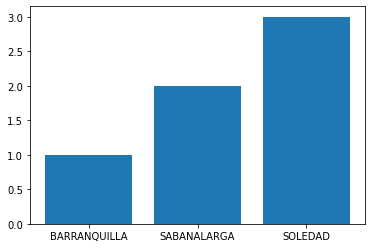

In [87]:
dpto_interes= clean_df[clean_df["Departamento_ocurrencia"] == "ATLANTICO"] #Dpto de interes
Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["CON_FIN"]].value_counts().reset_index() #agrupa municipio por columan de condicion final
MasMuertos_list =Con_Final[Con_Final["CON_FIN"] == 2].sort_values(by=0, ascending=False).reset_index().values.tolist()[0]
 #lista desendente de casos de muerte :2, [0]: pioscion con mas muertos
print("El municipio mas muertos registrados es:", MasMuertos_list[1], ".CANT:", MasMuertos_list[3] )


Con_Fin = Con_Final[Con_Final["CON_FIN"] == 2]

plt.bar(Con_Fin["Municipio_ocurrencia"], Con_Fin[0])
plt.show()



### DEPARTAMENTO

#### NUMERO DE HOSPITALIZADOS

In [88]:
dpto_info = clean_df[clean_df["Departamento_ocurrencia"] == "ATLANTICO"]
dpto_search=dpto_info[dpto_info["PAC_HOS"] == 1] # selecciona los pacientes Hospitalizados en el dpto de interes, (1): hospitalizado
#muertos = len(clean_df[dpto_info["PAC_HOS"] == 1].axes[0])
Pac_Hos=len(dpto_search)
print(Pac_Hos)

#df_list = dpto_search.values.tolist()
#print(len(df_list))
#print(df_list)

12333


#### CANTIDAD DE CASOS POR SEXO

In [89]:
dpto_info = clean_df[clean_df["Departamento_ocurrencia"] == "VICHADA"]
dpto_searchM=dpto_info[dpto_info["SEXO"] == "M"] # selecciona l"masculinos" en el dpto de interes, (1): hospitalizado
SEXOM=len(dpto_searchM.axes[0])
dpto_searchF=dpto_info[dpto_info["SEXO"] == "F"] # selecciona "femeninos" en el dpto de interes
SEXOF=len(dpto_searchF.axes[0])
print("numero de mujeres: ", SEXOF)
print("numero de hombres: ",SEXOM)
list = [SEXOM, SEXOF]


numero de mujeres:  749
numero de hombres:  868


### TEMPORALES

#### MES CON MAS CASOS

In [90]:
dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == "ATLANTICO"]
fecha = dpto_interes.groupby("FEC_NOT").value_counts().reset_index()
#Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["FEC_NOT"]].value_counts().reset_index()
fecha['MES'] = pd.to_datetime(fecha["FEC_NOT"]).dt.month
FLista= fecha['MES'].value_counts().reset_index().values.tolist()[0]
#Con_Final['MES'].value_counts()
#fecha['MES'].strftime(%m)

print("Mes:", FLista[0], "Registro mayor numero de casos")

Mes: 1 Registro mayor numero de casos


#### DIA CON MAS CASOS

In [91]:

dpto_interes = clean_df[clean_df["Departamento_ocurrencia"] == "ATLANTICO"]
fecha = dpto_interes.groupby("FEC_NOT").value_counts().reset_index()
#Con_Final = dpto_interes.groupby("Municipio_ocurrencia")[["FEC_NOT"]].value_counts().reset_index()
fecha['DIA'] = pd.to_datetime(fecha["FEC_NOT"]).dt.day
FLista= fecha['DIA'].value_counts().reset_index().values.tolist()[0]
#Con_Final['MES'].value_counts()
#fecha['MES'].strftime(%m)

print("Dia:", FLista[0], "Registro mayor numero de casos")

Dia: 4 Registro mayor numero de casos


### CODE TO RUN

In [92]:
lista_d = DoubleLinkedList()

for i,dpto in enumerate(clean_df["Departamento_ocurrencia"].unique()[:-1]): # ["Departamento_ocurrencia"].unique()[:-1] : hasta la penultima 
    #print(dpto)
    lista_d.AddNode(i, dpto) #i : dpto index , dpto: dpto name

fin = True
print("---------- BIENVENIDO AL CENTRO DE CONSULTAS SOBRE EL DENGUE ----------")
print("Ingresa tu nombre:")
print()
name = input()
print("Hola ", name, ", que deseas consultar?")

while fin:
    print("Escoge una opción: 1) Consultas por departamento 2) Consultas por municipio 3) Consultas temporales 4) Modelos 5) Salir")
    print()
    op = input()
    
    while (op != "1" and op != "2" and op != "3" and op != "4"):
        print("Recuerda que las opciones son del 1 al 5")
        print("Escoge una opción: 1) Consultas por departamento 2) Consultas por municipio 3) Consultas temporales 4) Modelos 5) Salir")
        print()
        op = input()
    
    if (fin):
        print("¿Que departamento desea consultar?")
        print()
        dpto = input()
        while(not(lista_d.Search(dpto))):
            print("Departamento no encontrado")
            print()
            dpto = input()
        
    if (op == "1"):
        print(".......... CONSULTAS POR DEPARTAMENTO ..........")
        print("El numero de hospitalizados en el departamento ", dpto)
        lista_d.num_hospitalizados(dpto)
        print("El numero de hospitalizados por sexo fue: ")
        lista_d.num_sexo(dpto)
        
    elif(op == "2"):
        print(".......... CONSULTAS POR MUNICIPIO ..........")
        lista_d.casos_municipio(dpto)
        lista_d.muertos_municipio(dpto)
        
    elif(op == "3"):
        print(".......... CONSULTAS TEMPORALES ..........")
        lista_d.mes_casos(dpto)
        lista_d.dia_casos(dpto)
    
    elif(op == "4"):
        reg_ll = models()
        
        print("Seleccione que tipo de proceso desea:\
            // 1 for Linear regression model\
            // 2 for Logistic regression model\
            // 3 for logistic regression DataFrame (with predicted values)\
            // 4 for correlation matrix")

        opt = int(input(print("Digite el número de su elección aquí: ")))

        if opt == 1:
            print(".......... LINEAR REGRESSION MODEL ..........")
            reg_ll.modelRLinear()

        if opt == 2:
            print(".......... LOGISTIC REGRESSION MODEL ..........")
            reg_ll.modeloRLogistic()

        if opt == 3:
            print(".......... LOGISTIC REGRESSION DATAFRAME ..........")
            reg_ll.dfReglog()
            
        if opt == 4:
            print(".......... CORRELATION MATRIX ..........")
            reg_ll.corrMatrix()
                
    elif(op == "5"): #Salir
        print("---------- GRACIAS POR USAR NUESTROS SERVICIOS, VUELVA PRONTO :) -----------")
        fin = False


KeyboardInterrupt: 

## RUN REGRESSION MODELS

In [21]:
reg_ll = models()

print("Seleccione que tipo de proceso desea:\
    // 1 for Linear regression model\
    // 2 for Logistic regression model\
    // 3 for logistic regression DataFrame (with predicted values)\
    // 4 for correlation matrix")

opt = int(input(print("Digite el número de su elección aquí: ")))

if opt == 1:
    reg_ll.modelRLinear()

if opt == 2: 
    reg_ll.modeloRLogistic()

if opt == 3:
    reg_ll.dfReglog()
    
if opt == 4:
    reg_ll.corrMatrix()

Seleccione que tipo de proceso desea:    // 1 for Linear regression model    // 2 for Logistic regression model    // 3 for logistic regression DataFrame (with predicted values)    // 4 for correlation matrix
Digite el número de su elección aquí: 


ValueError: invalid literal for int() with base 10: ''

###